## Install PySINDy via git

In [1]:
!git clone https://github.com/luckystarufo/pySINDy.git

Cloning into 'pySINDy'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 16784 (delta 3), reused 2 (delta 0), pack-reused 16770
Receiving objects: 100% (16784/16784), 94.13 MiB | 19.52 MiB/s, done.
Resolving deltas: 100% (3017/3017), done.
Checking out files: 100% (14406/14406), done.


In [4]:
!ls

pySINDy  sample_data


In [5]:
%cd pySINDy

/content/pySINDy


In [6]:
!pip install -e .

Obtaining file:///content/pySINDy
  Created wheel for findiff: filename=findiff-0.8.0-cp36-none-any.whl size=13015 sha256=67626df05447f3746732032bfff668b4c7ea23ccc8c22f3aeb10f4332b9d4e4a
  Stored in directory: /root/.cache/pip/wheels/1a/6b/70/530ad7a4513e3c750abd5b3010abde5edd9904652488fceda8
Successfully built findiff
  Running setup.py develop for PySINDy


## Import modules and packages

In [0]:
from pySINDy.sindy import SINDy
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

### Retrieve training data from https://github.com/CSSEGISandData/COVID-19

The following cells download csvs from CSSEGISandData/COVID-19 repo.

Time-series records in Hubei will be used as training data

In [0]:
df_train_c = pd.read_csv("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv")
df_train_d = pd.read_csv("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv")
df_train_r = pd.read_csv("https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv")

In [0]:
xc = df_train_c[df_train_c["Province/State"] == "Hubei"].values[0, 4:]
xd = df_train_d[df_train_d["Province/State"] == "Hubei"].values[0, 4:]
xr = df_train_r[df_train_r["Province/State"] == "Hubei"].values[0, 4:]

In [ ]:
x_train = np.concatenate(
    [
     xc[None, ...],
     xr[None, ...],
     xd[None, ...]
    ],
    axis=0
).astype(np.float32)

### Visusalize training data (Hubei)

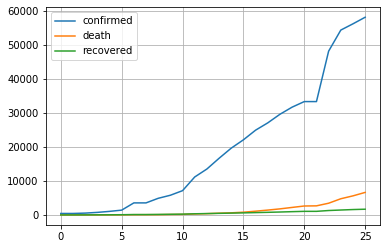

In [24]:
plt.plot(x_train.T)
plt.grid()
plt.legend(["confirmed", "death", "recovered"])

## Create SINDY model

In [0]:
model = SINDy(name='covid-19')

### Fit on training data

In [52]:
model.fit(x_train, 1, poly_degree=2, cut_off=1e-3)

In [53]:
# coefficient matrix
model.coefficients

array([[ 7.9984662e+02,  1.4988913e+01,  5.4111018e+00],
       [-3.2379520e-01,  6.0601331e-02,  0.0000000e+00],
       [-1.6269997e+01,  1.1709479e-01, -2.9132338e-02],
       [ 1.5485686e+01, -1.8800216e+00,  1.7136915e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 3.5516437e-02,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [44]:
# library of nonlinear terms
model.descriptions

['1', 'u0', 'u1', 'u2', 'u0^{2}', 'u0u1', 'u1^{2}', 'u0u2', 'u1u2', 'u2^{2}']

## Test trained model

We will set latest record in Japan as initial condition and predict Japan's future infections using the model we just trained 

In [0]:
# manually build ode function using obtained coefficient
def dxdt(x, t):
  dx1 = 7.9984662e+02 + (-3.2379520e-01*x[0]) + (-1.6269997e+01*x[1]) +  1.5485686e+01*x[2] + 3.5516437e-02*(x[2]**2)
  dx2 = 1.4988913e+01 + 6.0601331e-02*x[0] + 1.1709479e-01*x[1] + (-1.8800216*x[2])
  dx3 = 5.4111018 + (-2.9132338e-02*x[1]) + 1.7136915e-01*x[2]
  return [dx1, dx2, dx3]

### Use latest record in Japan as initial value

In [0]:
test_xc = df_train_c[df_train_c["Country/Region"] == "Japan"].values[0, -1]
test_xd = df_train_d[df_train_d["Country/Region"] == "Japan"].values[0, -1]
test_xr = df_train_r[df_train_r["Country/Region"] == "Japan"].values[0, -1]
test_x0 = np.array([test_xc, test_xd, test_xr])

In [0]:
t = np.linspace(0, 30, 100)

In [0]:
sol = odeint(dxdt, test_x0, t)

### Visualize the predicted result (Japan)

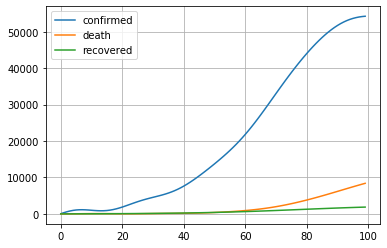

In [49]:
plt.plot(sol)
plt.grid()
plt.legend(["confirmed", "death", "recovered"])